In [3]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [4]:
# Load dataset Iris
iris = load_iris()
X = iris.data
y = iris.target

# Split menjadi data train dan test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisasi fitur (biar lebih optimal untuk Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Langkah 3: Definisi Objective Function
#### Di Optuna, kita perlu bikin fungsi objektif yang akan dicari nilainya. Fungsi ini:
#### 1️⃣ Menerima trial dari Optuna.
#### 2️⃣ Memilih kombinasi hyperparameter.
#### 3️⃣ Melatih model Logistic Regression.
#### 4️⃣ Mengembalikan skor akurasi.

In [5]:
def objective(trial):
    # Pilih nilai C (regularization strength) secara otomatis
    # 📌 trial.suggest_float('C', 0.01, 10.0, log=True)
    # ➡️ trial.suggest_float(...) → Meminta Optuna mencari nilai float untuk C.
    # ➡️ 'C' → Nama hyperparameter yang sedang dicari.
    # ➡️ 0.01, 10.0 → Rentang nilai C yang akan dicoba oleh Optuna.
    # ➡️ log=True → Optuna memilih nilai dalam skala logaritmik (karena C biasanya lebih efektif dicari dalam skala log).
    # float -> bisa di rubah tergantung tipe datanya
    
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    
    # Buat model Logistic Regression dengan hyperparameter C yang dipilih
    model = LogisticRegression(C=C, random_state=42, max_iter=200)

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi di data test
    y_pred = model.predict(X_test)

    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # Optuna akan mencari nilai tertinggi dari ini


#### Kalau beda algoritma beda lagi ini :
#### C = trial.suggest_float('C', 0.01, 10.0, log=True)
#### Buat model Logistic Regression dengan hyperparameter C yang dipilih
#### model = LogisticRegression(C=C, random_state=42, max_iter=200)

## Langkah 4: Jalankan Optuna untuk Mencari Hyperparameter Terbaik

In [6]:
# Buat study Optuna
study = optuna.create_study(direction='maximize')  # Kita mau cari akurasi tertinggi
# 1️⃣ maximize → Kalau kita mau mencari nilai terbesar (misalnya, akurasi, F1-score, R²).
# 2️⃣ minimize → Kalau kita mau mencari nilai terkecil (misalnya, error seperti MSE, MAE, log-loss).

study.optimize(objective, n_trials=50)  # Coba 50 kombinasi hyperparameter

# 🔹 Penjelasan:
# ✅ optuna.create_study(direction='maximize') → Kita mau maksimalkan akurasi.
# ✅ study.optimize(objective, n_trials=50) → Optuna akan mencoba 50 trial untuk menemukan C terbaik.


[I 2025-03-21 13:32:20,937] A new study created in memory with name: no-name-7ef6ae01-eb2d-4ca4-bccf-517f3d2e2c4b
[I 2025-03-21 13:32:20,964] Trial 0 finished with value: 0.9 and parameters: {'C': 0.13177522644861964}. Best is trial 0 with value: 0.9.


[I 2025-03-21 13:32:20,972] Trial 1 finished with value: 0.8666666666666667 and parameters: {'C': 0.10947026690241907}. Best is trial 0 with value: 0.9.
[I 2025-03-21 13:32:20,980] Trial 2 finished with value: 0.9666666666666667 and parameters: {'C': 4.797035770885202}. Best is trial 2 with value: 0.9666666666666667.
[I 2025-03-21 13:32:20,988] Trial 3 finished with value: 0.9666666666666667 and parameters: {'C': 5.188379727078182}. Best is trial 2 with value: 0.9666666666666667.
[I 2025-03-21 13:32:20,994] Trial 4 finished with value: 0.8 and parameters: {'C': 0.019387088572545057}. Best is trial 2 with value: 0.9666666666666667.
[I 2025-03-21 13:32:21,001] Trial 5 finished with value: 0.9666666666666667 and parameters: {'C': 2.501921609670612}. Best is trial 2 with value: 0.9666666666666667.
[I 2025-03-21 13:32:21,007] Trial 6 finished with value: 0.9666666666666667 and parameters: {'C': 2.514781529849005}. Best is trial 2 with value: 0.9666666666666667.
[I 2025-03-21 13:32:21,015] T

In [7]:
print(f"Best Hyperparameter: {study.best_trial.params}")
print(f"Best Accuracy: {study.best_trial.value:.4f}")

Best Hyperparameter: {'C': 9.776459715285089}
Best Accuracy: 1.0000


In [9]:
# 1️⃣ Coba Evaluasi Model dengan Hyperparameter Terbaik

best_C = study.best_trial.params['C']  # Ambil C terbaik dari hasil tuning

# Train ulang model dengan C terbaik
best_model = LogisticRegression(C=best_C, random_state=42)
best_model.fit(X_train, y_train)

# Evaluasi di test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Final Model Accuracy: {accuracy:.4f}")


Final Model Accuracy: 1.0000


## 1️⃣ Cek Overfitting atau Tidak

In [10]:
# cross validation score
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# confusion matrix & classification report 
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Accuracy: 0.9667 ± 0.0312
Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



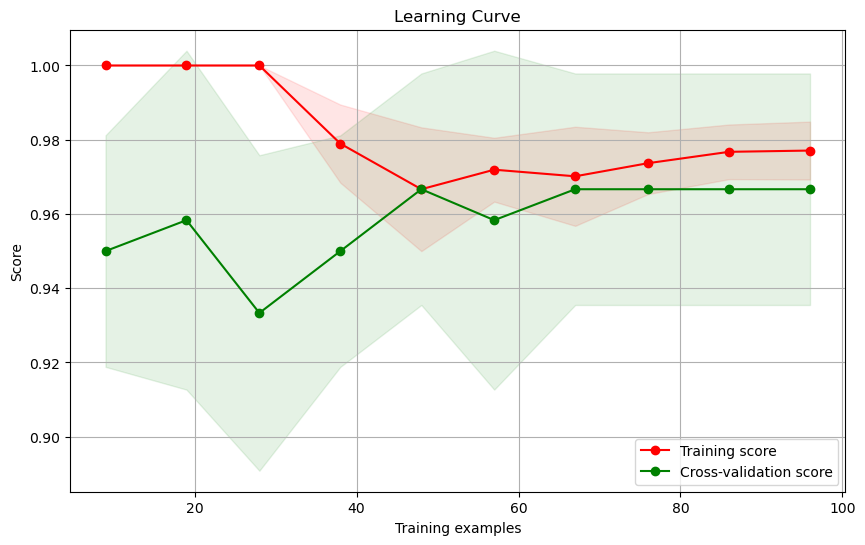

In [11]:
# learning curve berdasarkan training model

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()